# SLT-CE-2: Histogram Clustering

In this coding exercise, you will segment an image with histogram clustering (HC). You will implement two different methods: maximum a posterior probability (MAP) and deterministic annealing (DA) for predicting the cluster membership for each pixel.

<h2 style="background-color:#f0b375;"> References </h2>

[1] Histogram clustering for unsupervised image segmentation: http://ieeexplore.ieee.org/document/784981 (If you cannot access, you can try the same link after configuring your ETH VPN.)

[2] Lecture Slides 5: https://ml2.inf.ethz.ch/courses/slt/lectures/slt23_lecture05.pdf

[3] Lecture script: https://ml2.inf.ethz.ch/courses/slt/lectures/SLT_Script.pdf, chapter 2.7

<h2 style="background-color:#f0b375;"> Setup </h2>

In [1]:
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

from sklearn.utils.validation import check_is_fitted
from matplotlib.image import imread

In [11]:
!curl -LJO https://github.com/marvin-koch/Statistical-Learning-Theory/raw/main/slt-ce-2/texture.png


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  141k  100  141k    0     0   232k      0 --:--:-- --:--:-- --:--:--  232k


In [12]:
!curl -LJO https://github.com/marvin-koch/Statistical-Learning-Theory/raw/main/slt-ce-2/environment.yaml


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  237k    0  237k    0     0   759k      0 --:--:-- --:--:-- --:--:--  761k


## Texture and corresponding label map
(This texture is used to fit your model.)

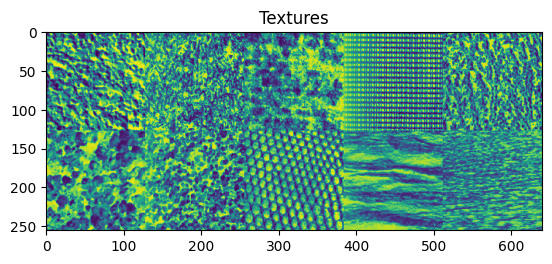

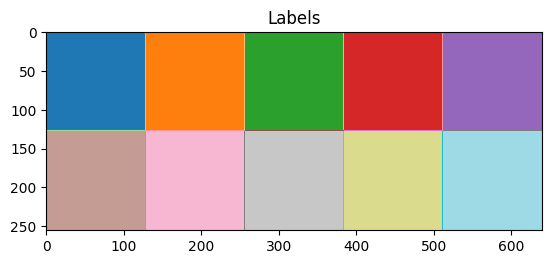

In [2]:
texture = imread("texture.png")

patch_grid_shape = (2, 5)
patch_shape = (128, 128)
label_map = np.ones(texture.shape)
for patch in range(np.prod(patch_grid_shape)):
    i, j = np.unravel_index(patch, patch_grid_shape)
    label_map[patch_shape[0] * i:patch_shape[0] * (i + 1), \
              patch_shape[1] * j:patch_shape[1] * (j + 1)] = np.ravel_multi_index((i, j), patch_grid_shape)

plt.imshow(texture)
plt.title("Textures")
plt.figure()
plt.imshow(label_map, cmap="tab20")
plt.title("Labels")
plt.show()

## Permuted texture and label map
(The permuted texture is used for the prediction)

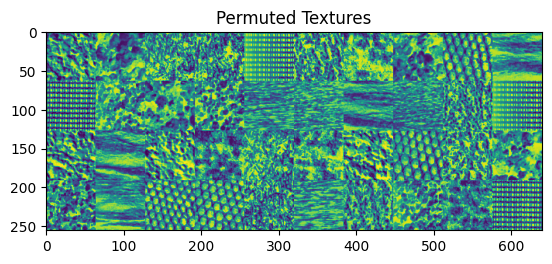

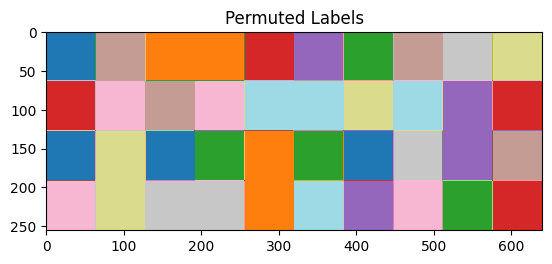

In [3]:
perm_patch_grid_shape = tuple(i * 2 for i in patch_grid_shape)
perm_patch_shape = tuple(i // 2 for i in patch_shape)
n_perm_patches = np.prod(patch_grid_shape) * 4

np.random.seed(5)
perm = np.random.permutation(n_perm_patches)

perm_texture = np.ones(texture.shape)
perm_label_map = np.ones(texture.shape)

for patch, perm_patch in enumerate(perm):
    i, j = np.unravel_index(patch, perm_patch_grid_shape) * np.array(perm_patch_shape)
    ip, jp = np.unravel_index(perm_patch, perm_patch_grid_shape) * np.array(perm_patch_shape)

    perm_texture[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = texture[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

    perm_label_map[ip:ip + perm_patch_shape[0], jp:jp + perm_patch_shape[1]] \
        = label_map[i:i + perm_patch_shape[0], j:j + perm_patch_shape[1]]

plt.imshow(perm_texture)
plt.title("Permuted Textures")
plt.figure()
plt.imshow(perm_label_map, cmap="tab20")
plt.title("Permuted Labels")
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
    Read the references and recapitulate the parameter estimation formulas for both: maximum a posteriori probability estimation (MAP) and Deterministic Annealing (DA) estimation. In particular, write down how equation (5) in reference <a href=http://ieeexplore.ieee.org/document/784981>[1]</a> looks for the case of DA (using the notation of reference [1]).<br>
Hint: try to derive $\hat P(y|c)$ from $\hat P(c|x)$ and use the maximum entropy principle to find $\hat P(c|x)$.<br>
Hint 2: See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.
</p>

Put your recap here.

In the case of DA, equation (5) becomes $\hat{P}(y|c)=\dots$

In [29]:
from sklearn.feature_extraction import image

class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)

    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).

    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """

    def __init__(self, n_clusters=10, n_bins=64, window_size=7, random_state=42, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation
        # Add more parameters, if necessary.

    def hist(self, patches, norm=False):
        h = np.histogram(patches[patches>-1], np.linspace(0, 1, self.n_bins + 1))[0]
        return h / np.sum(h) if norm == True else h

    def get_histogram(self, patches, normalize=False):
        hist = np.histogram(patches[patches>-1], np.linspace(0, 1, self.n_bins + 1))[0]
        if normalize:
            return hist / np.sum(hist)
        else:
            return hist

    def fit(self, X):
        """Compute HC for input image X

        Compute centroids.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            self
        """
        np.random.seed(self.random_state)
        pad_wid= int((self.window_size-1)/2)
        padded_array = np.lib.pad(X, ((pad_wid,pad_wid),(pad_wid,pad_wid)), 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded_array, (self.window_size, self.window_size))
        hists = np.apply_along_axis(self.get_histogram, 1, np.reshape(patches, (X.shape[0] * X.shape[1], -1)), True)

        if self.estimation == "MAP":
          # Code for Maximum a Posteriori estimation
          self.centroids = np.random.rand(self.n_clusters, self.n_bins)
          self.centroids = self.centroids / np.sum(self.centroids, 1)[:, np.newaxis] # normalize

          predictions =  np.argmin(-hists @ np.log(self.centroids).T,1)
          delta = 1
          for i in range(100):
            for c in range(self.n_clusters):
              indices = np.where(predictions == c)[0]
              self.centroids[c] = np.mean(hists[indices],0)

            self.centroids += 1e-9
            new_pred =  np.argmin(-hists @ np.log(self.centroids).T,1)
            delta = np.sum(new_pred - predictions)
            predictions = new_pred.copy()

          self.centroids = self.centroids / np.sum(self.centroids, 1)[:, np.newaxis] # normalize

        elif self.estimation == "DA":
            print("hey")
            # Code for Deterministic Annealing estimation

        return self

    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width)
        """
        check_is_fitted(self, ["centroids"])
        pad_wid= int((self.window_size-1)/2)
        padded_array = np.lib.pad(X, ((pad_wid,pad_wid),(pad_wid,pad_wid)), 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded_array, (self.window_size, self.window_size))
        hists = np.apply_along_axis(self.get_histogram, 1, np.reshape(patches, (X.shape[0] * X.shape[1], -1)), True)

        # Your code goes here

        new_pred = np.argmin(-hists @ np.log(self.centroids).T,1)
        C = np.reshape(new_pred, (X.shape[0], X.shape[1]))

        return C

    def generate(self, C):
        """Generate a sample image X from a texture label map C.

        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).

        Args:
            C (np.ndarray): Input array with shape (height, width)

        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])

        # Your code goes here

        return X

In [71]:
class HistogramClustering(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for HistogramClustering (HC)

    Attributes:
        centroids (np.ndarray): Array of centroid distributions p(y|c) with shape (n_clusters, n_bins).

    Parameters:
        n_clusters (int): Number of clusters (textures).
        n_bins (int): Number of bins used to discretize the range of pixel values found in input image X.
        window_size (int): Size of the window used to compute the local histograms for each pixel.
                           Should be an odd number larger or equal to 3.
        random_state (int): Random seed.
        estimation (str): Whether to use Maximum a Posteriori ("MAP") or
                          Deterministic Annealing ("DA") estimation.
    """

    def __init__(self, n_clusters=10, n_bins=128, window_size=15, random_state=14504, estimation="MAP"):
        self.n_clusters = n_clusters
        self.n_bins =n_bins
        self.window_size = window_size
        self.random_state = random_state
        self.estimation = estimation

    def histogram(self, areas, normalize):
        h = np.histogram(areas[areas>-1], np.linspace(0, 1, self.n_bins + 1))[0]
        normalizer = np.sum(h) if normalize else 1
        return h / normalizer

    def create_hist(self, X):
        pad_wid= int((self.window_size-1)/2)
        padded_array = np.lib.pad(X, ((pad_wid,pad_wid),(pad_wid,pad_wid)), 'constant', constant_values=((-1, -1),(-1, -1)))
        patches = image.extract_patches_2d(padded_array, (self.window_size, self.window_size))
        return np.apply_along_axis(self.histogram, 1, np.reshape(patches, (X.shape[0] * X.shape[1], -1)), True)

    def fit(self, X):
        """Compute HC for input image X

        Compute centroids.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            self
        """
        np.random.seed(self.random_state)

        hists = self.create_hist(X)



        if self.estimation == "MAP":

            self.centroids = np.random.rand(self.n_clusters, self.n_bins)
            self.centroids /= np.sum(self.centroids, axis=1, keepdims=True)


            # first round initialize
            predictions = np.argmin(-hists @ np.log(self.centroids).T, 1)
            delta = 1
            while not delta == 0:
                for c in range(self.n_clusters):
                    indices = np.where(predictions == c)[0]
                    self.centroids[c] = np.mean(hists[indices], 0)

                self.centroids = self.centroids + 1e-9
                new_predictions = np.argmin(-hists @ np.log(self.centroids).T, 1)


                delta = np.sum(new_predictions - predictions)
                predictions = new_predictions

            self.centroids /= np.sum(self.centroids, axis=1, keepdims=True)


        elif self.estimation == "DA":

           print("hello")
        return self


    def predict(self, X):
        """Predict cluster assignments for each pixel in image X.

        Args:
            X (np.ndarray): Input array with shape (height, width)

        Returns:
            C (np.ndarray): Assignment map (height, width)
        """
        check_is_fitted(self, ["centroids"])
        # Your code goes here
        hists = self.create_hist(X)



        if self.estimation == "MAP":
            assignments = np.argmin(-hists @ np.log(self.centroids).T, 1)
            C = np.reshape(assignments, (X.shape[0], X.shape[1]))

        elif self.estimation == "DA":
            if T is None:
                T = self.T_zero
            pxk = np.array([-np.sum(np.multiply(hists, np.log(np.divide(hists, k + 10e-4) + 10e-10)), axis=1) / T
                   for k in self.centroids])
            pxk = np.exp(pxk)
            p = np.moveaxis(pxk/np.sum(pxk, 0), 0, 1)
            assignments = np.argmax(p, 1)
            C = np.reshape(assignments, (X.shape[0], X.shape[1]))

        return C

    def generate(self, C):
        """Generate a sample image X from a texture label map C.

        The entries of C are integers from the set {1,...,n_clusters}. They represent the texture labels
        of each pixel. Given the texture labels, a sample image X is generated by sampling
        the value of each pixel from the fitted p(y|c).

        Args:
            C (np.ndarray): Input array with shape (height, width)

        Returns:
            X (np.ndarray): Sample image (height, width)
        """
        check_is_fitted(self, ["centroids"])
        X = np.zeros(C.shape)
        bins= np.linspace(0, 1, self.n_bins+1)
        for height_i in range(0, patch_shape[0]):
            for width_i in range(0, patch_shape[1]):
                choice = random.random()
                bin_idx = np.where(np.array(choice < np.cumsum(self.centroids[C[height_i, width_i]]), dtype=int) == 1)[0][0]
                X[height_i, width_i] = np.random.uniform(bins[bin_idx], bins[bin_idx+1],1)
        return X

<p style="background-color:#adebad;">
Implement the "MAP" part of the <b>fit method</b> for the template class HistogramClustering, according to the contract outlined in its docstring. You can add more class methods if necessary. Create an instance of your HC class with n_clusters = 10 and fit the image texture. Record the execution time.
</p>

In [72]:
%%time
HC = HistogramClustering()
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

CPU times: user 21.3 s, sys: 4.56 s, total: 25.8 s
Wall time: 22.7 s


<h2 style="background-color:#f0b375;">
Section 4.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>predict method</b> for the template class HC, according to the contract outlined in its docstring.
        </li>        
        <li>
            Use HC.predict to predict the texture labels of perm_texture. Plot the predicted label map.
        </li>
    </ul>
</p>

In [73]:
%%time
predicted_perm_label_map = HC.predict(perm_texture)

CPU times: user 14.7 s, sys: 464 ms, total: 15.2 s
Wall time: 15.2 s


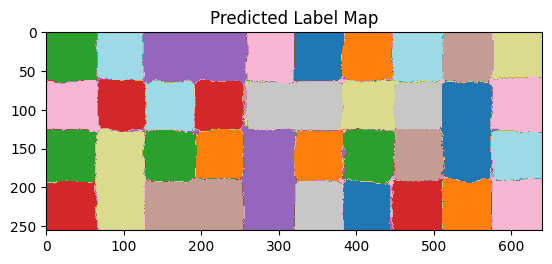

In [79]:
# Plot of predicted label map
plt.figure()
plt.title("Predicted Label Map")
plt.imshow(predicted_perm_label_map, cmap="tab20")
plt.show()

<p style="background-color:#adebad;">
    Plot the confusion matrix for your predictions, using the perm_label_map. Make sure to permute the texture labels appropriately, to make them correspond to the true labels (see Hungarian algortihm to find the best match).
</p>

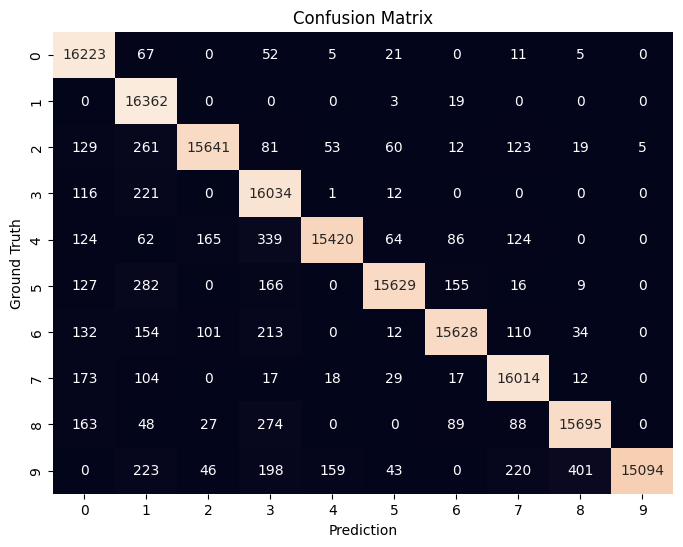

In [96]:
# Confusion matrix

import numpy as np
import seaborn as sns

import numpy as np

def correspondance(given_map, predict_map, n_clusters):
    given_flat = given_map.ravel()
    predict_flat = predict_map.ravel()

    common_counts = np.zeros((n_clusters, n_clusters), dtype=int)

    for pred_cluster in range(n_clusters):
        for given_cluster in range(n_clusters):
            common_indices = np.intersect1d(np.where(predict_flat == pred_cluster)[0],
                                            np.where(given_flat == given_cluster)[0])
            common_counts[pred_cluster, given_cluster] = len(common_indices)

    mapping = {pred_cluster: np.argmax(common_counts[pred_cluster]) for pred_cluster in range(n_clusters)}
    new_predict_flat = np.vectorize(mapping.get)(predict_flat)
    new_predict_map = new_predict_flat.reshape(predict_map.shape)
    return new_predict_map, mapping


    # Apply the mapping to change the colors of the predicted map
    new_predict_map_flat = np.vectorize(mapping.get)(predict_map_flat)
    new_predict_map = new_predict_map_flat.reshape(predict_map.shape)

    return new_predict_map, mapping

corr = correspondance(perm_label_map, predicted_perm_label_map, 10)[0]

from sklearn.metrics import confusion_matrix, accuracy_score
y_true = np.ravel(perm_label_map)
pred_labels = np.ravel(corr)
conf_matrix = confusion_matrix(y_true, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('Confusion Matrix')
plt.show()


<p style="background-color:#adebad;">
    Using n_clusters=10, fit HC with all combinations of n_bins = 16, 32, 64 and window_size = 7, 9, 11.
    For each setting compute the accuracy of the prediction on perm_texture. Show the results in a 3x3 matrix and label the axes properly.
</p>

KeyError: 'accuracy'

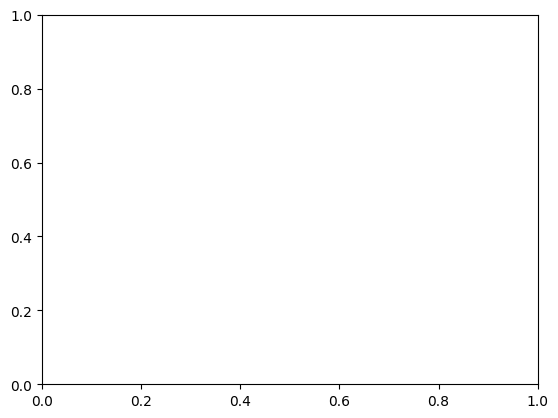

In [100]:
# 3x3 Matrix with accuracy scores of the different parameter combination
bin_sizes = [16, 32, 64]
window_sizes = [7, 9, 11]
results = []
accuracies = []

for bin_size in bin_sizes:
    for window_size in window_sizes:
        HC = HistogramClustering(n_bins=bin_size, window_size=window_size)
        HC.fit(texture)
        predicted_labels = HC.predict(perm_texture)
        corr, _ = correspondance(perm_label_map, predicted_labels, n_clusters=10)

        true_labels = np.ravel(perm_label_map)
        pred_labels = np.ravel(corr)
        accuracy = accuracy_score(true_labels, pred_labels)
        accuracies.append(accuracy)

        results.append({'bin_size': bin_size, 'window_size': window_size, 'correspondance': corr})

# Plotting the results
fig, ax = plt.subplots()
accuracy_matrix = np.array([a for a in accuracies]).reshape(len(window_sizes), len(bin_sizes))

cax = ax.matshow(accuracy_matrix)
fig.colorbar(cax)

ax.set_xticklabels([''] + bin_sizes)
ax.set_yticklabels([''] + window_sizes)
ax.set_xlabel('n_bins')
ax.set_ylabel('window_size')
ax.set_title('Accuracy Matrix')

for i in range(len(window_sizes)):
    for j in range(len(bin_sizes)):
        ax.text(j, i, f'{accuracy_matrix[j,i]:.4f}', ha='center', va='center', color='black')

plt.show()


<p style="background-color:#adebad;">
    For each setting plot the prediction (i.e. the clustering) of the texture (perm_texture) itself. Arrange the plots next to each other in a grid and label them accordingly.
    </p>

TypeError: Image data of dtype <U8 cannot be converted to float

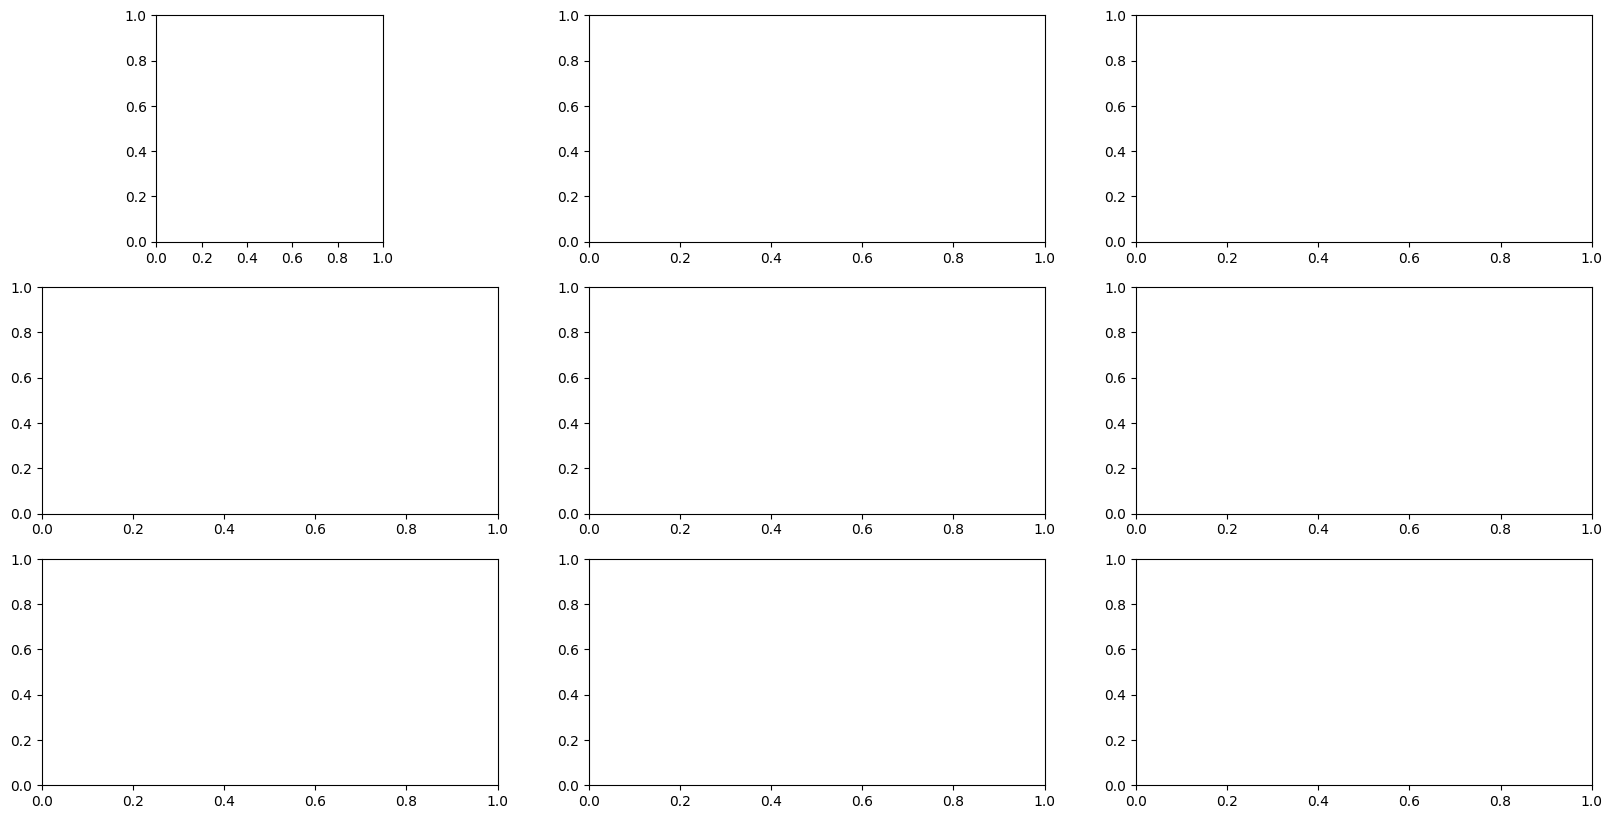

In [94]:
# Cluster predictions (9 plots arranged in a 3x3 grid)
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

for i, (bin_size, window_size, corr) in enumerate(results):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.imshow(matched_preds, cmap="tab20")
    ax.set_title(f'n_bins: {bin_size}, window_size: {window_size}')

plt.tight_layout()
plt.show()


<h2 style="background-color:#f0b375;">
Section 5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5 </span>
</h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>generate</b> method for the template class HC, according to the contract outlined in its docstring.
        </li>
        <li>
        Use HC.generate to generate ten 128x128 patches, one for each texture. Plot the generated textures next to the ground truth textures.
        </li>
    </ul>

In [ ]:
C1 = np.ones(patch_shape) * 0
X1 = HC.generate(C1)

# C2, C3, etc. You can also use a more suitable data structure to loop over the textures.

# Generated texture plot

<h2 style="background-color:#f0b375;">
Section 5.5
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<ul style="background-color:#adebad;">
    <li>
        Use k-means clustering to cluster the pixels of the texture (perm_texture). Set n_clusters=10, and use the local histogram vectors as features. Compare the predicted label map with k-means with the predicted label map obtained by HC.
    </li>
</ul>

In [ ]:
# Predicted label map for k-means
# Predicted label map for HC

<ul style="background-color:#adebad;">
    <li>
        Plot and compare the confusion matrices for both, k-means, and HC.
    </li>
</ul>

In [ ]:
# Confusion matrices

<ul style="background-color:#adebad;">
        <li>
Plot the centroid histograms $\hat P(y|c)$ after fitting the texture image, one centroid histogram for every texture image. Compare them to the empirical histograms (i.e. show them both in one plot).
        </li>
    </ul>

In [ ]:
# Histograms

<h2 style="background-color:#f0b375;">
Section 6.0
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Implement the "DA" part of HC.fit.
        </li>
    </ul>

In [ ]:
%%time
HC = HistogramClustering(estimation="DA")
HC.fit(texture)
check_is_fitted(HC, ["centroids"])

<ul style="background-color:#adebad;">
        <li>
        Plot the clustering (predicted labels) of the texture (perm_texture) at different temperatures during the annealing schedule. Describe what you observe.
        </li>
    </ul>

In [ ]:
# Clustering at different temperatures

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.